## Projet de MODS206 - Nowcasting and Dynamic Factor Models

### BASTIDE Simon, RISTORCELLI Ulysse, VUJASINOVIC Thomas

Analyse des bases de données de base, en se restreignant aux fréquences mensuelles :

In [636]:
#imports
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import plotly.graph_objects as go
import plotly.io as pio
import datetime as dt
pio.templates.default = "plotly_white"

In [637]:
#imports de capitalisations boursières des grandes entreprises du tourisme
def get_data(assets, start_date, end_date):
    """
    Récupère les données des actions sur Yahoo Finance
    """
    return yf.download(assets, start=start_date, end=end_date)['Adj Close']

assets = ['0H59.IL', 'ALVDM.PA']
N = 5000 # Complétez avec le nombre de jours historiques

start_date = dt.datetime.now() - dt.timedelta(days=N)
end_date = dt.datetime.now()

data = get_data(assets, start_date, end_date)
data
monthly_data = data.resample('M').mean()
monthly_data =  monthly_data['2011-01':'2024-01']
monthly_data = monthly_data / monthly_data.iloc[0]
monthly_data

[*********************100%%**********************]  2 of 2 completed


Ticker,0H59.IL,ALVDM.PA
Date,,
2011-01-31,1.000000,1.000000
2011-02-28,1.058638,0.885070
2011-03-31,1.025012,0.862617
2011-04-30,0.991209,0.836040
2011-05-31,0.974374,0.831754
...,...,...
2023-09-30,1.337704,5.862802
2023-10-31,1.230715,5.343185
2023-11-30,1.238059,5.652081


In [638]:
# Affichage des données superposé avec plotly pour une année 
fig = go.Figure()
for a in assets:
    fig.add_trace(go.Scatter(x=data.index, y=data[a], name=a))
fig.update_layout(title='Evolution des prix des actifs', yaxis_title='Prix en $')
fig.show()

In [639]:

# Cleaning sight seeing demand data
sight_seeing_demand_df=pd.read_csv('databases/famille_SUIVI-DEMANDE-TOURISTIQUE/valeurs_mensuelles.csv', sep=';')
sight_seeing_demand_df=sight_seeing_demand_df.drop(sight_seeing_demand_df[sight_seeing_demand_df['Libellé'] == 'Codes'].index)
sight_seeing_demand_df=sight_seeing_demand_df.drop('Période', axis=1)

sight_seeing_demand_df = sight_seeing_demand_df.transpose()
sight_seeing_demand_df.columns = sight_seeing_demand_df.iloc[0]
sight_seeing_demand_df = sight_seeing_demand_df.drop(sight_seeing_demand_df.index[:3])
sight_seeing_demand_df = sight_seeing_demand_df.apply(pd.to_numeric, errors='ignore')

sight_seeing_demand_df = sight_seeing_demand_df / sight_seeing_demand_df.iloc[0]
sight_seeing_demand_df

# Cleaning overnight stays data
overnight_stays_df=pd.read_csv('databases/famille_NUITEE/valeurs_mensuelles.csv', sep=';')
overnight_stays_df=overnight_stays_df.drop(overnight_stays_df[overnight_stays_df['Libellé'] == 'Codes'].index)
overnight_stays_df=overnight_stays_df.drop('Période',axis=1)

regions=[
    "Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne",
    "Centre-Val de Loire", "Corse", "Grand Est", "Hauts-de-France",
    "Ile-de-France", "Normandie", "Nouvelle-Aquitaine", "Occitanie",
    "Pays de la Loire", "Provence Alpes Côte d’Azur"
]

overnight_stays_df_t = overnight_stays_df.transpose()
overnight_stays_df_t.columns = overnight_stays_df_t.iloc[0]
overnight_stays_df_t = overnight_stays_df_t.drop(overnight_stays_df_t.index[:3])

occupation_columns = [col for col in overnight_stays_df_t.columns if "Taux d'occupation dans l'hôtellerie" in col]
overnight_columns = [col for col in overnight_stays_df_t.columns if "Nuitées dans l'hôtellerie - Total -" in col and "Série arrêtée" not in col]
arrival_columns= [col for col in overnight_stays_df_t.columns if "Arrivées dans l'hôtellerie - Total -" in col and "Série arrêtée" not in col]

selected_occupation_columns = [col for col in occupation_columns if any(region in col for region in regions)]
selected_overnight_columns = [col for col in overnight_columns if any(region in col for region in regions)]
selected_arrival_columns = [col for col in arrival_columns if any(region in col for region in regions)]

selected_columns = selected_arrival_columns+selected_occupation_columns+selected_overnight_columns

overnight_stays_df_t =overnight_stays_df_t[selected_columns]
overnight_stays_df_t=overnight_stays_df_t['2011-01':]
overnight_stays_df_t.index = pd.to_datetime(overnight_stays_df_t.index)
overnight_stays_df_t = overnight_stays_df_t.resample('M').mean()

overnight_stays_df_t = overnight_stays_df_t.apply(pd.to_numeric, errors='ignore')
overnight_stays_df_t = overnight_stays_df_t / overnight_stays_df_t.iloc[0]
overnight_stays_df_t

Libellé,Arrivées dans l'hôtellerie - Total - Occitanie,Arrivées dans l'hôtellerie - Total - Pays de la Loire,Arrivées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Arrivées dans l'hôtellerie - Total - Corse-du-Sud,Arrivées dans l'hôtellerie - Total - Grand Est,Arrivées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Arrivées dans l'hôtellerie - Total - Normandie,Arrivées dans l'hôtellerie - Total - Corse,Arrivées dans l'hôtellerie - Total - Hauts-de-France,Arrivées dans l'hôtellerie - Total - Nouvelle-Aquitaine,...,Nuitées dans l'hôtellerie - Total - Normandie,Nuitées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Nuitées dans l'hôtellerie - Total - Grand Est,Nuitées dans l'hôtellerie - Total - Nouvelle-Aquitaine,Nuitées dans l'hôtellerie - Total - Occitanie,Nuitées dans l'hôtellerie - Total - Corse-du-Sud,Nuitées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Nuitées dans l'hôtellerie - Total - Haute-Corse,Nuitées dans l'hôtellerie - Total - Centre-Val de Loire,Nuitées dans l'hôtellerie - Total - Hauts-de-France
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.119617,1.064378,1.147860,1.188718,1.047836,1.095344,1.233184,1.235294,1.073171,1.141089,...,1.209302,1.145089,1.052786,1.141707,1.188474,1.219235,1.134247,1.214572,0.969595,1.042308
2011-03-31,1.277512,1.227468,1.369650,1.625641,1.284738,1.175166,1.479821,1.882353,1.262195,1.482673,...,1.465116,1.199219,1.322581,1.528180,1.327103,1.777778,1.339726,1.972778,1.226351,1.251923
2011-04-30,1.765550,1.476395,1.583658,5.793846,1.542141,1.074279,2.008969,5.882353,1.487805,1.940594,...,2.098837,0.938616,1.590909,2.070853,2.009346,6.676225,1.545205,6.425140,1.591216,1.451923
2011-05-31,2.031100,1.510730,1.704280,11.798974,1.624146,1.044346,2.017937,11.411765,1.503049,1.997525,...,2.110465,0.840960,1.683284,2.165862,2.395639,13.247909,1.682192,12.277022,1.844595,1.490385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,2.327751,1.969957,1.968872,12.532308,1.986333,1.444568,2.372197,13.352941,1.713415,2.485149,...,2.436047,1.145647,2.080645,2.663446,2.633956,16.401434,1.950685,16.527622,2.070946,1.703846
2023-10-31,1.916268,1.686695,1.579767,7.002051,1.753986,1.157428,1.883408,6.900000,1.548780,2.086634,...,1.959302,0.920759,1.815249,2.204509,2.121495,8.436081,1.591781,7.010408,1.726351,1.548077
2023-11-30,1.253589,1.291845,1.140078,1.631795,1.419134,0.927938,1.327354,1.823529,1.237805,1.445545,...,1.366279,0.742188,1.473607,1.470209,1.305296,1.574074,1.169863,1.908727,1.246622,1.273077
2023-12-31,1.296651,1.111588,1.217899,1.372308,1.874715,1.186253,1.183857,1.523529,1.310976,1.475248,...,1.223837,1.059710,1.989736,1.434783,1.299065,1.240143,1.169863,1.566053,1.192568,1.288462


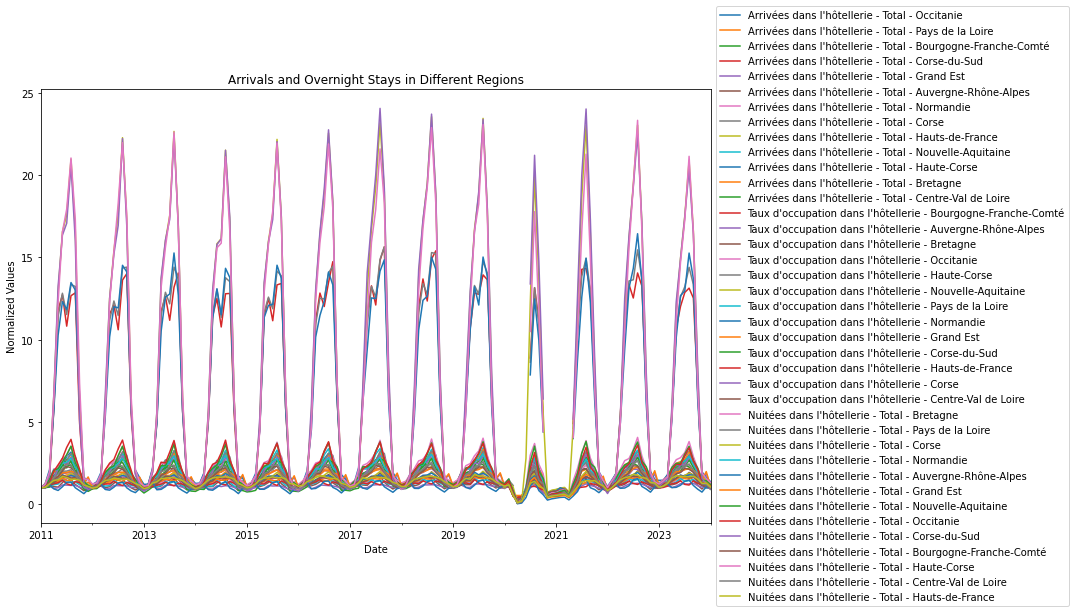

In [655]:
# Plotting overnight stays data
ax = overnight_stays_df_t.plot(figsize=(12, 8))
plt.title('Arrivals and Overnight Stays in Different Regions')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [641]:
# Cleaning exchange rate data
change_rate_pd = pd.read_csv('databases/euro change rates.csv', sep=',')

change_rate_pd['Date'] = pd.to_datetime(change_rate_pd['Date'])

change_rate_pd = change_rate_pd[change_rate_pd['Date'] > "2010-12-31"]
change_rate_pd = change_rate_pd[change_rate_pd['Date'] < "2024-01-31"]
change_rate_pd.drop(columns=['Unnamed: 42'], inplace=True)

change_rate_pd.set_index('Date', inplace=True)

change_rate_pd = change_rate_pd.resample('M').mean()

change_rate_pd = change_rate_pd[['USD', 'GBP', 'JPY', 'CNY']]
change_rate_pd = change_rate_pd / change_rate_pd.iloc[0]

change_rate_pd


,USD,GBP,JPY,CNY
Date,,,,
2011-01-31,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.021653,0.999100,1.021626,1.019140
2011-03-31,1.047869,1.022919,1.036387,1.042514
2011-04-30,1.080999,1.042256,1.090906,1.069419
2011-05-31,1.074027,1.036312,1.055139,1.057210
...,...,...,...,...
2023-09-30,0.799706,1.017078,1.429551,0.884434
2023-10-31,0.790629,1.024632,1.431748,0.875736
2023-11-30,0.809019,1.027549,1.466232,0.885802


In [642]:

# Load CPI index data
cpi_index_df = pd.read_csv("databases/CPI deflated EER-41Euro.csv", sep=',')
cpi_index_df['DATE'] = pd.to_datetime(cpi_index_df['DATE'])
cpi_index_df.set_index('DATE', inplace=True)
cpi_index_df = cpi_index_df[cpi_index_df.index > "2010-12-31"]
cpi_index_df = cpi_index_df[['CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)']]

cpi_index_df = cpi_index_df / cpi_index_df.iloc[0]
cpi_index_df


,CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)
DATE,
2011-01-31,1.000000
2011-02-28,1.011901
2011-03-31,1.027736
2011-04-30,1.044303
2011-05-31,1.033249
...,...
2023-10-31,0.982445
2023-11-30,0.985851
2023-12-31,0.980746


In [643]:
# Concatenate overnight stays, exchange rate, stock prices and CPI index data
data = pd.concat([overnight_stays_df_t, change_rate_pd, monthly_data, cpi_index_df], axis=1)
data = data.drop(data.index[-1])
data

,Arrivées dans l'hôtellerie - Total - Occitanie,Arrivées dans l'hôtellerie - Total - Pays de la Loire,Arrivées dans l'hôtellerie - Total - Bourgogne-Franche-Comté,Arrivées dans l'hôtellerie - Total - Corse-du-Sud,Arrivées dans l'hôtellerie - Total - Grand Est,Arrivées dans l'hôtellerie - Total - Auvergne-Rhône-Alpes,Arrivées dans l'hôtellerie - Total - Normandie,Arrivées dans l'hôtellerie - Total - Corse,Arrivées dans l'hôtellerie - Total - Hauts-de-France,Arrivées dans l'hôtellerie - Total - Nouvelle-Aquitaine,...,Nuitées dans l'hôtellerie - Total - Haute-Corse,Nuitées dans l'hôtellerie - Total - Centre-Val de Loire,Nuitées dans l'hôtellerie - Total - Hauts-de-France,USD,GBP,JPY,CNY,0H59.IL,ALVDM.PA,CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)
2011-01-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2011-02-28,1.119617,1.064378,1.147860,1.188718,1.047836,1.095344,1.233184,1.235294,1.073171,1.141089,...,1.214572,0.969595,1.042308,1.021653,0.999100,1.021626,1.019140,1.058638,0.885070,1.011901
2011-03-31,1.277512,1.227468,1.369650,1.625641,1.284738,1.175166,1.479821,1.882353,1.262195,1.482673,...,1.972778,1.226351,1.251923,1.047869,1.022919,1.036387,1.042514,1.025012,0.862617,1.027736
2011-04-30,1.765550,1.476395,1.583658,5.793846,1.542141,1.074279,2.008969,5.882353,1.487805,1.940594,...,6.425140,1.591216,1.451923,1.080999,1.042256,1.090906,1.069419,0.991209,0.836040,1.044303
2011-05-31,2.031100,1.510730,1.704280,11.798974,1.624146,1.044346,2.017937,11.411765,1.503049,1.997525,...,12.277022,1.844595,1.490385,1.074027,1.036312,1.055139,1.057210,0.974374,0.831754,1.033249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,2.327751,1.969957,1.968872,12.532308,1.986333,1.444568,2.372197,13.352941,1.713415,2.485149,...,16.527622,2.070946,1.703846,0.799706,1.017078,1.429551,0.884434,1.337704,5.862802,0.987515
2023-10-31,1.916268,1.686695,1.579767,7.002051,1.753986,1.157428,1.883408,6.900000,1.548780,2.086634,...,7.010408,1.726351,1.548077,0.790629,1.024632,1.431748,0.875736,1.230715,5.343185,0.982445
2023-11-30,1.253589,1.291845,1.140078,1.631795,1.419134,0.927938,1.327354,1.823529,1.237805,1.445545,...,1.908727,1.246622,1.273077,0.809019,1.027549,1.466232,0.885802,1.238059,5.652081,0.985851
2023-12-31,1.296651,1.111588,1.217899,1.372308,1.874715,1.186253,1.183857,1.523529,1.310976,1.475248,...,1.566053,1.192568,1.288462,0.816117,1.017194,1.424273,0.883333,1.372846,6.031865,0.980746


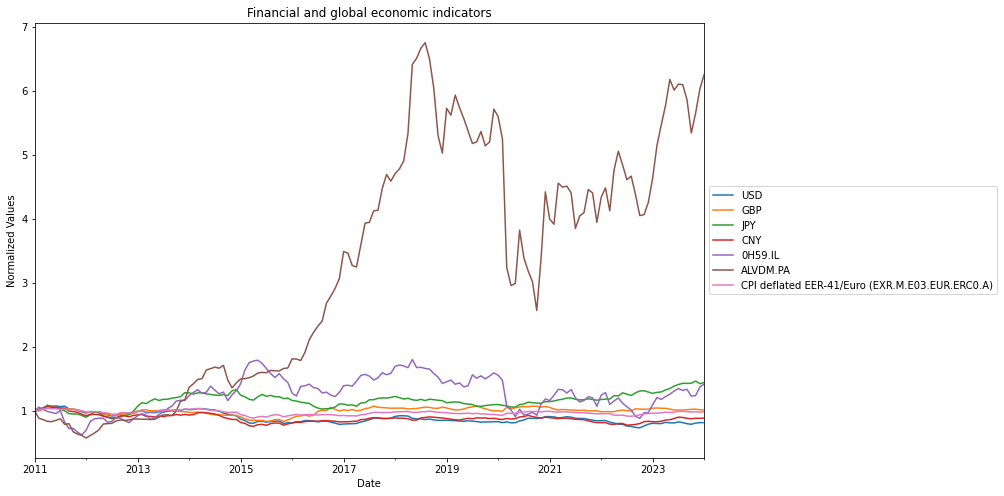

In [657]:
ax = data[['USD','GBP','JPY','CNY','0H59.IL','ALVDM.PA','CPI deflated EER-41/Euro (EXR.M.E03.EUR.ERC0.A)']].plot(figsize=(12, 8))
plt.title('Financial and global economic indicators')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

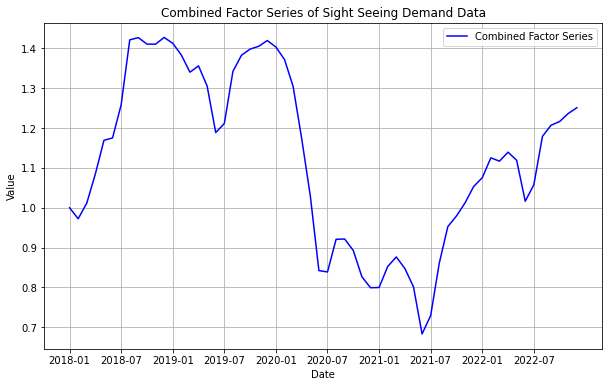

In [644]:
# Factor series using simple moving average
def calculate_sma(series, window=10):
    return series.rolling(window=window, min_periods=1).mean()  

sight_seeing_demand_df_numeric = sight_seeing_demand_df.apply(pd.to_numeric, errors='coerce')
factor_series = sight_seeing_demand_df_numeric.apply(calculate_sma)
combined_factor_series = factor_series.mean(axis=1)  


tick_frequency = 6 
plt.figure(figsize=(10, 6))
plt.plot(combined_factor_series.index, combined_factor_series.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series of Sight Seeing Demand Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(combined_factor_series.index[::tick_frequency])
plt.show()

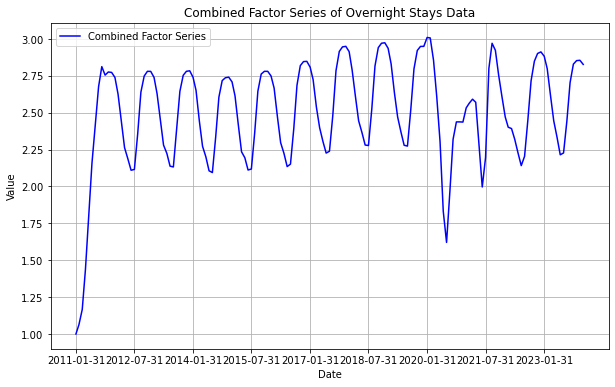

In [645]:
factor_series_2 = overnight_stays_df_t.apply(calculate_sma)
combined_factor_series_2 = factor_series_2.mean(axis=1)  


tick_frequency = 6 
plt.figure(figsize=(10, 6))
plt.plot(combined_factor_series_2.index, combined_factor_series_2.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series of Overnight Stays Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(combined_factor_series_2.index[::tick_frequency*3])
plt.show()

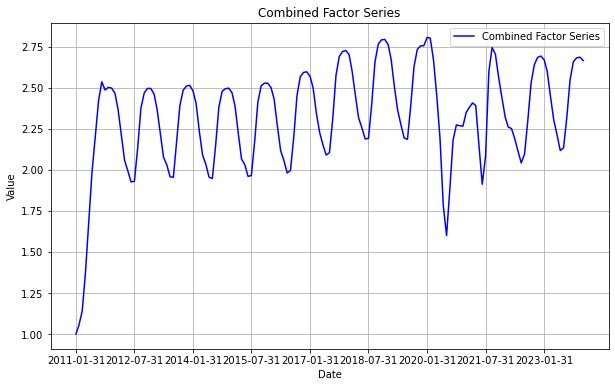

In [646]:
facser = data.apply(calculate_sma)
comb_facser = facser.mean(axis=1)  

plt.figure(figsize=(10, 6))
plt.plot(comb_facser.index, comb_facser.values, label='Combined Factor Series', color='blue')
plt.title('Combined Factor Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(comb_facser.index[::tick_frequency*3])
plt.show()

In [647]:
"""
def calculate_wma(series, window=10):
    weights = np.arange(1, window + 1)  # Define weights (linearly increasing)
    return series.rolling(window=window, min_periods=1).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

factor_series_wma = data.apply(calculate_wma, axis=0)

combined_factor_series_wma = factor_series_wma.mean(axis=1)  

plt.figure(figsize=(10, 6))
plt.plot(combined_factor_series_wma.index, combined_factor_series_wma.values, label='Combined Factor Series (WMA)', color='red')
plt.title('Combined Factor Series with Weighted Moving Average')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(comb_facser.index[::tick_frequency*3])
plt.show()
"""

"\ndef calculate_wma(series, window=10):\n    weights = np.arange(1, window + 1)  # Define weights (linearly increasing)\n    return series.rolling(window=window, min_periods=1).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)\n\nfactor_series_wma = data.apply(calculate_wma, axis=0)\n\ncombined_factor_series_wma = factor_series_wma.mean(axis=1)  \n\nplt.figure(figsize=(10, 6))\nplt.plot(combined_factor_series_wma.index, combined_factor_series_wma.values, label='Combined Factor Series (WMA)', color='red')\nplt.title('Combined Factor Series with Weighted Moving Average')\nplt.xlabel('Date')\nplt.ylabel('Value')\nplt.legend()\nplt.grid(True)\nplt.xticks(comb_facser.index[::tick_frequency*3])\nplt.show()\n"

In [648]:
# Define the indicator function for Vigipirate periods
vigipirate_periods = [
    (pd.to_datetime("2012-03-31"), pd.to_datetime("2012-03-31").replace(day=31)),
    (pd.to_datetime("2015-01-31"), pd.to_datetime("2015-01-31").replace(day=31)),
    (pd.to_datetime("2015-02-28"), pd.to_datetime("2015-02-28").replace(day=28)), 
    (pd.to_datetime("2015-06-30"), pd.to_datetime("2015-06-30").replace(day=30)),
    (pd.to_datetime("2015-11-30"), pd.to_datetime("2015-11-30").replace(day=30)),
    (pd.to_datetime("2016-03-31"), pd.to_datetime("2016-03-31").replace(day=31)),
    (pd.to_datetime("2016-06-30"), pd.to_datetime("2016-06-30").replace(day=30)),
    (pd.to_datetime("2016-07-31"), pd.to_datetime("2016-07-31").replace(day=31)),
    (pd.to_datetime("2016-09-30"), pd.to_datetime("2016-09-30").replace(day=30)),
    (pd.to_datetime("2017-06-30"), pd.to_datetime("2017-06-30").replace(day=30)),
    (pd.to_datetime("2017-09-30"), pd.to_datetime("2017-09-30").replace(day=30)),
    (pd.to_datetime("2018-02-28"), pd.to_datetime("2018-02-28").replace(day=28)),
    (pd.to_datetime("2018-12-31"), pd.to_datetime("2018-12-31").replace(day=31)),
    (pd.to_datetime("2021-03-31"), pd.to_datetime("2021-03-31").replace(day=31)),
    (pd.to_datetime("2023-10-31"), pd.to_datetime("2023-10-31").replace(day=31))
]

date_range = pd.date_range(start="2011-01-31", end="2024-01-31", freq="M")

vigipirate_indicator = []

for date in date_range:
    is_vigipirate_active = any(start <= date <= end for start, end in vigipirate_periods)
    vigipirate_indicator.append(1 if is_vigipirate_active else 0)

vigipirate_df = pd.DataFrame({
    "Date": date_range,
    "Vigipirate_Indicator": vigipirate_indicator
})

vigipirate_df.set_index("Date", inplace=True)
vigipirate_df

,Vigipirate_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,0
2023-10-31,1
2023-11-30,0


In [649]:
# Define the indicator function for the NOTRe law

date_range = pd.date_range(start='2011-01-31', end='2024-01-31', freq='M')

law_effective_date = pd.to_datetime('2015-03-31')

indicator_data = {'Date': date_range,
                  'Loi_NOTRe_Indicator': (date_range >= law_effective_date).astype(int)}

indicator_df = pd.DataFrame(indicator_data)

indicator_df.set_index('Date', inplace=True)
indicator_df

,Loi_NOTRe_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,1
2023-10-31,1
2023-11-30,1


In [650]:
# Define the indicator function for the COVID-19 pandemic
covid_periods = [
    (pd.to_datetime("2020-03-01"), pd.to_datetime("2021-12-31")) 
]

date_range = pd.date_range(start="2011-01-31", end="2024-01-31", freq="M")

covid_indicator = []

for date in date_range:
    is_covid_active = any(start <= date <= end for start, end in covid_periods)
    covid_indicator.append(1 if is_covid_active else 0)
covid_df = pd.DataFrame({
    "Date": date_range,
    "COVID_Indicator": covid_indicator
})

covid_df.set_index("Date", inplace=True)
covid_df

,COVID_Indicator
Date,
2011-01-31,0
2011-02-28,0
2011-03-31,0
2011-04-30,0
2011-05-31,0
...,...
2023-09-30,0
2023-10-31,0
2023-11-30,0


In [651]:
import statsmodels.api as sm

# Combine factor series with indicator function(s)
df = pd.concat([facser, vigipirate_df, indicator_df, covid_df], axis=1)


# Define variables
# Assuming 'Treatment_Variable' is your treatment variable and 'Outcome_Variable' is your outcome variable
X = df[['Vigipirate_Indicator', 'Loi_NOTRe_Indicator', 'COVID_Indicator']]  # Independent variables
X = sm.add_constant(X) 
y =  comb_facser # Dependent variable

# Estimate regression model (with interaction terms)
model = sm.OLS(y, X)
results = model.fit()

# Check assumptions and model fit
print(results.summary())




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     6.396
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           0.000413
Time:                        09:49:32   Log-Likelihood:                -34.403
No. Observations:                 157   AIC:                             76.81
Df Residuals:                     153   BIC:                             89.03
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.1795 